<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Javier González</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [61]:
import numpy as np

def cargar_datos_ligo(nombre_archivo):
  datos = []
  with open(nombre_archivo, 'r') as f:
    for linea in f:
      # Intentar convertir la línea a un número de punto flotante
      try:
        valor = float(linea.strip())
        datos.append(valor)
      except ValueError:
        # Ignorar la línea si no se puede convertir
        pass
  
  return np.array(datos)
# Ejemplo de uso
nombre_archivo = "L-L1_GWOSC_16KHZ_R1-1187008867-32.txt"
#nombre_archivo = "L-L1_GWOSC_16KHZ_R1-1185389792-32.txt"
datos = cargar_datos_ligo(nombre_archivo)

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

In [62]:
import numpy as np
from scipy.io import wavfile

def guardar_audio(datos, nombre_archivo, frecuencia_muestreo=16000):
  # Normalizar los datos al rango [-1, 1]
  datos_normalizados = datos / np.max(np.abs(datos))
  
  # Convertir a enteros de 16 bits
  datos_enteros = np.int16(datos_normalizados * 32767)
  
  wavfile.write(nombre_archivo, frecuencia_muestreo, datos_enteros)

nombre_archivo_audio = "senal_ligo.wav"
guardar_audio(datos, nombre_archivo_audio)

## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


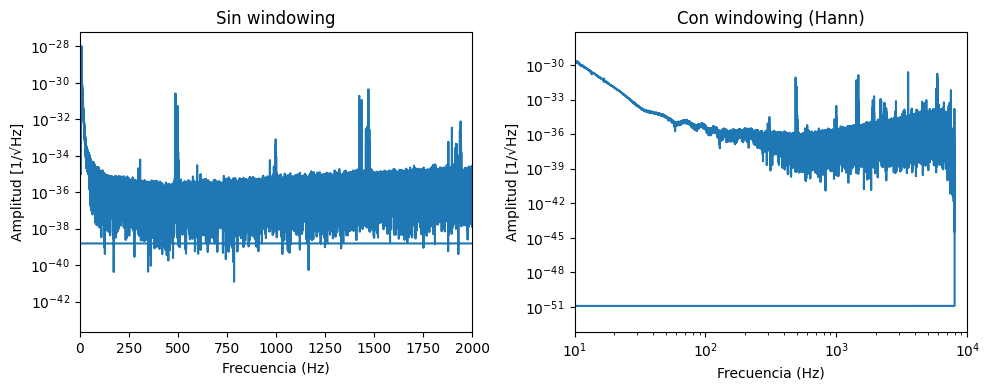

In [103]:
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import get_window, butter, lfilter
import matplotlib.pyplot as plt

def analisis_fourier(datos, frecuencia_muestreo):
  # Aplicar la FFT
  transformada = fft(datos)
  
  # Calcular las frecuencias
  frecuencias = fftfreq(len(datos), 1/frecuencia_muestreo)
  
  # Calcular la densidad espectral de potencia
  densidad_espectral = np.abs(transformada) ** 2

  return frecuencias, densidad_espectral



# Ejemplo de uso
#nombre_archivo_datos = "L-L1_GWOSC_16KHZ_R1-1185389792-32.txt"
nombre_archivo_datos = "L-L1_GWOSC_16KHZ_R1-1187008867-32.txt"
#nombre_archivo_datos = "H-H1_GWOSC_16KHZ_R1-1126259447-32.txt"
datos = cargar_datos_ligo(nombre_archivo_datos)
frecuencia_muestreo = 16000

# Análisis de Fourier con los datos filtrados (corrección)
frecuencias, densidad_espectral = analisis_fourier(datos, frecuencia_muestreo)

# Aplicar una función de ventana (por ejemplo, Hann)
ventana = get_window("hann", len(datos))
datos_ventana = datos * ventana

# Análisis de Fourier con windowing
frecuencias_ventana, densidad_espectral_ventana = analisis_fourier(datos_ventana, frecuencia_muestreo)

# Eliminar la componente de corriente continua
densidad_espectral[0] = 0


# Graficar la amplitud en escala logarítmica
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(frecuencias, densidad_espectral)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [1/√Hz]")
plt.yscale("log")
plt.xlim(0, 2000)
plt.title("Sin windowing")

plt.subplot(1, 2, 2)
plt.plot(frecuencias_ventana, densidad_espectral_ventana)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud [1/√Hz]")
plt.yscale("log")
plt.xscale("log")
plt.xlim(10, 10000)
plt.title("Con windowing (Hann)")

plt.tight_layout()
plt.show()



## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.